# Preparation

In [3]:
import tensorflow as tf
import os
e = "No gpu"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6148)])
  except RuntimeError as e:
    print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [4]:
import miscnn

# Creating a Data I/O interface for kidney tumor CT scans in NIfTI format
from miscnn.data_loading.interfaces import NIFTI_interface

In [5]:
interface = NIFTI_interface(pattern="case_00[0-9]*", channels=1, classes=3)

In [6]:
data_path = "/media/rami/New Volume/kits19/data_resized/"
data_io = miscnn.Data_IO(interface, data_path)

In [7]:
sample_list = data_io.get_indiceslist()
sample_list.sort()
print("All samples: " + str(sample_list))

All samples: ['case_00000', 'case_00001', 'case_00002', 'case_00003', 'case_00004', 'case_00005', 'case_00006', 'case_00007', 'case_00008', 'case_00009', 'case_00010', 'case_00011', 'case_00012', 'case_00013', 'case_00014', 'case_00015', 'case_00016', 'case_00017', 'case_00018', 'case_00019', 'case_00020', 'case_00021', 'case_00022', 'case_00023', 'case_00024', 'case_00025', 'case_00026', 'case_00027', 'case_00028', 'case_00029', 'case_00030', 'case_00031', 'case_00032', 'case_00033', 'case_00034', 'case_00035', 'case_00036', 'case_00037', 'case_00038', 'case_00039', 'case_00040', 'case_00041', 'case_00042', 'case_00043', 'case_00044', 'case_00045', 'case_00046', 'case_00047', 'case_00048', 'case_00049', 'case_00050', 'case_00051', 'case_00052', 'case_00053', 'case_00054', 'case_00055', 'case_00056', 'case_00057', 'case_00058', 'case_00059', 'case_00060', 'case_00061', 'case_00062', 'case_00063', 'case_00064', 'case_00065', 'case_00066', 'case_00067', 'case_00068', 'case_00069', 'case_

In [8]:
# Data Augmentation
from miscnn.processing.data_augmentation import Data_Augmentation

# Configurations
data_aug = Data_Augmentation(cycles=2, scaling=True, rotations=True, elastic_deform=True, mirror=True,
                             brightness=True, contrast=True, gamma=True, gaussian_noise=True)

In [9]:
#Subfunctions
from miscnn.processing.subfunctions.normalization import Normalization
from miscnn.processing.subfunctions.clipping import Clipping
from miscnn.processing.subfunctions.resampling import Resampling

# Pixel value normalization Subfunction through Z-Score 
sf_normalize = Normalization(mode='z-score')
# Clipping Subfunction between -79 and 304
sf_clipping = Clipping(min=-79, max=304)
# Resampling Subfunction to voxel spacing 3.22 x 1.62 x 1.62
sf_resample = Resampling((3.22, 1.62, 1.62))

# Creating the list for Subfunctions
subfunctions = [sf_resample, sf_clipping, sf_normalize]

In [10]:
# Preprocessor
from miscnn.processing.preprocessor import Preprocessor
data = data_io

# Configure the Preprocessor class
pp = Preprocessor(data, data_aug=data_aug, batch_size=1, subfunctions=subfunctions, prepare_subfunctions=True, 
                  prepare_batches=False, analysis="patchwise-crop", patch_shape=(80, 80, 80),
                  use_multiprocessing=True)

# Patch overlap for predictions
pp.patchwise_overlap = (40, 40, 40)

In [11]:
# Network Model - Standard 3D Unet
from miscnn.neural_network.model import Neural_Network
#Specify loss functions to import
from miscnn.neural_network.metrics import dice_soft, dice_crossentropy, focal_tversky, background, kidney, tumor, log_cosh_dice_loss, dice_soft_loss
from miscnn.neural_network.architecture.unet.standard import Architecture

unet_standard = Architecture()
# Create the Neural Network model
model = Neural_Network(preprocessor=pp, architecture=unet_standard ,loss= dice_soft_loss, metrics=[dice_soft, dice_crossentropy, background, kidney, tumor],
                       batch_queue_size=1, workers=3, learninig_rate=0.0001)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, None, None, N 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, N 128         conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, None, None, N 27680       batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
cb_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)

from tensorflow.keras.callbacks import EarlyStopping
cb_es = EarlyStopping(monitor='loss', min_delta=0, patience=20, verbose=1, mode='min')

from tensorflow.keras.callbacks import CSVLogger
filename = "/media/rami/New Volume/kits19/MIScnn/Training results/Standard_tversky/train.csv"
tf.keras.callbacks.CSVLogger(filename, separator=",", append=False)
csv_logger = CSVLogger('training.csv')


from keras.callbacks import ModelCheckpoint
filepath= "/media/rami/New Volume/kits19/MIScnn/Trials/weight_improvement_{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [14]:
# Excluding suspious samples from data set
del sample_list[133]
del sample_list[125]
del sample_list[68]
del sample_list[37]
del sample_list[23]
del sample_list[15]

#Create train sample
train_samples = sample_list[0:160]
# Create the validation sample ID list
validation_samples = sample_list[160:204]
# Create the test sample ID list
test_samples = sample_list[204:294]
# Output validation samples
print("Validation samples: " + str(validation_samples))

Validation samples: ['case_00166', 'case_00167', 'case_00168', 'case_00169', 'case_00170', 'case_00171', 'case_00172', 'case_00173', 'case_00174', 'case_00175', 'case_00176', 'case_00177', 'case_00178', 'case_00179', 'case_00180', 'case_00181', 'case_00182', 'case_00183', 'case_00184', 'case_00185', 'case_00186', 'case_00187', 'case_00188', 'case_00189', 'case_00190', 'case_00191', 'case_00192', 'case_00193', 'case_00194', 'case_00195', 'case_00196', 'case_00197', 'case_00198', 'case_00199', 'case_00200', 'case_00201', 'case_00202', 'case_00203', 'case_00204', 'case_00205', 'case_00206', 'case_00207', 'case_00208', 'case_00209']


In [29]:
#Check the elements
print(len(train_samples))
print(validation_samples[37:44])

160
['case_00203', 'case_00204', 'case_00205', 'case_00206', 'case_00207', 'case_00208', 'case_00209']


# Train

In [13]:
#To change the name of the pickle file if needed
import os
src = '61865142'
dst = '30326476'
for i in range (0,210):
   source= f'/media/rami/New Volume/kits19/MIScnn/batches/{src}.case_{i:05}.pickle'
   dest = f'/media/rami/New Volume/kits19/MIScnn/batches/{dst}.case_{i:05}.pickle'
   if(os.path.exists(source)):
    os.rename(source , dest)


In [18]:
# Training the model with 160 samples for 250 epochs

model.train(train_samples, epochs=250, callbacks=[csv_logger, cb_lr, cb_es, checkpoint])

Epoch 1/100
320/320 [==============================] - ETA: 0s - loss: 0.3981 - dice_soft: 0.7864 - dice_crossentropy: 0.1311 - background: 0.9644 - kidney: 0.8480 - tumor: 0.5468
Epoch 00001: loss improved from inf to 0.39813, saving model to /media/rami/New Volume/kits19/MIScnn/Trials/weight_improvement_01.hdf5
320/320 [==============================] - 93s 290ms/step - loss: 0.3981 - dice_soft: 0.7864 - dice_crossentropy: 0.1311 - background: 0.9644 - kidney: 0.8480 - tumor: 0.5468 - lr: 1.0000e-04
Epoch 2/100
320/320 [==============================] - ETA: 0s - loss: 0.3797 - dice_soft: 0.7956 - dice_crossentropy: 0.1284 - background: 0.9622 - kidney: 0.8571 - tumor: 0.5676
Epoch 00002: loss improved from 0.39813 to 0.37974, saving model to /media/rami/New Volume/kits19/MIScnn/Trials/weight_improvement_02.hdf5
320/320 [==============================] - 94s 293ms/step - loss: 0.3797 - dice_soft: 0.7956 - dice_crossentropy: 0.1284 - background: 0.9622 - kidney: 0.8571 - tumor: 0.5676

Epoch 19/100
320/320 [==============================] - ETA: 0s - loss: 0.3229 - dice_soft: 0.8255 - dice_crossentropy: 0.1083 - background: 0.9649 - kidney: 0.8790 - tumor: 0.6324
Epoch 00019: loss improved from 0.34703 to 0.32288, saving model to /media/rami/New Volume/kits19/MIScnn/Trials/weight_improvement_19.hdf5
320/320 [==============================] - 95s 295ms/step - loss: 0.3229 - dice_soft: 0.8255 - dice_crossentropy: 0.1083 - background: 0.9649 - kidney: 0.8790 - tumor: 0.6324 - lr: 1.0000e-05
Epoch 20/100
320/320 [==============================] - ETA: 0s - loss: 0.3376 - dice_soft: 0.8170 - dice_crossentropy: 0.1119 - background: 0.9653 - kidney: 0.8695 - tumor: 0.6162
Epoch 00020: loss did not improve from 0.32288
320/320 [==============================] - 90s 283ms/step - loss: 0.3376 - dice_soft: 0.8170 - dice_crossentropy: 0.1119 - background: 0.9653 - kidney: 0.8695 - tumor: 0.6162 - lr: 1.0000e-05
Epoch 21/100
320/320 [==============================] - ETA: 0s - lo

320/320 [==============================] - ETA: 0s - loss: 0.3409 - dice_soft: 0.8179 - dice_crossentropy: 0.1083 - background: 0.9652 - kidney: 0.8774 - tumor: 0.6110
Epoch 00057: loss did not improve from 0.30471
320/320 [==============================] - 91s 284ms/step - loss: 0.3409 - dice_soft: 0.8179 - dice_crossentropy: 0.1083 - background: 0.9652 - kidney: 0.8774 - tumor: 0.6110 - lr: 1.0000e-05
Epoch 58/100
320/320 [==============================] - ETA: 0s - loss: 0.3328 - dice_soft: 0.8234 - dice_crossentropy: 0.1061 - background: 0.9650 - kidney: 0.8854 - tumor: 0.6196
Epoch 00058: loss did not improve from 0.30471
320/320 [==============================] - 92s 288ms/step - loss: 0.3328 - dice_soft: 0.8234 - dice_crossentropy: 0.1061 - background: 0.9650 - kidney: 0.8854 - tumor: 0.6196 - lr: 1.0000e-05
Epoch 59/100
320/320 [==============================] - ETA: 0s - loss: 0.3341 - dice_soft: 0.8228 - dice_crossentropy: 0.1063 - background: 0.9655 - kidney: 0.8848 - tumor:

320/320 [==============================] - ETA: 0s - loss: 0.3208 - dice_soft: 0.8257 - dice_crossentropy: 0.1048 - background: 0.9657 - kidney: 0.8760 - tumor: 0.6354
Epoch 00095: loss did not improve from 0.29222
320/320 [==============================] - 92s 287ms/step - loss: 0.3208 - dice_soft: 0.8257 - dice_crossentropy: 0.1048 - background: 0.9657 - kidney: 0.8760 - tumor: 0.6354 - lr: 1.0000e-05
Epoch 96/100
320/320 [==============================] - ETA: 0s - loss: 0.2992 - dice_soft: 0.8358 - dice_crossentropy: 0.0994 - background: 0.9650 - kidney: 0.8821 - tumor: 0.6604
Epoch 00096: loss did not improve from 0.29222
320/320 [==============================] - 90s 282ms/step - loss: 0.2992 - dice_soft: 0.8358 - dice_crossentropy: 0.0994 - background: 0.9650 - kidney: 0.8821 - tumor: 0.6604 - lr: 1.0000e-05
Epoch 97/100
320/320 [==============================] - ETA: 0s - loss: 0.3097 - dice_soft: 0.8343 - dice_crossentropy: 0.0989 - background: 0.9650 - kidney: 0.8916 - tumor:

In [19]:
#Save model
model.dump("3DUnet_weighted_dice_final_run.hdf5")

# Graph

<Figure size 432x288 with 0 Axes>

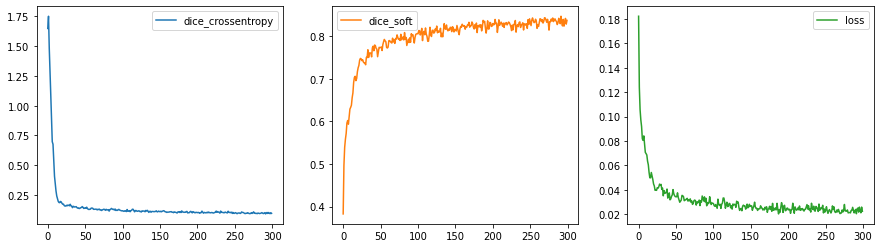

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt
data = pd.read_csv('Training results/Standard_log_cosh_dice_loss/full_iteration/training.csv')
data = data[["dice_crossentropy","dice_soft","loss"]]
plt.figure()
data.plot(subplots=True, layout=(1, 3), figsize=(15, 4), sharex=False);

<Figure size 432x288 with 0 Axes>

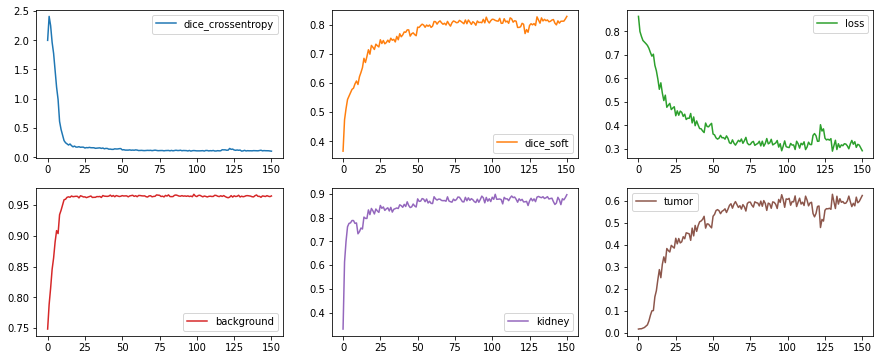

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
data = pd.read_csv('training.csv')
data = data[["dice_crossentropy","dice_soft","loss","background","kidney","tumor"]]
plt.figure()
data.plot(subplots=True, layout=(2, 3), figsize=(15, 6), sharex=False);

# Prediction

In [19]:
model.reset_weights()

In [30]:
model.load('3DUnet_dice_soft.hdf5')

In [31]:
model.predict(validation_samples)

# Evaluation

In [32]:
from evaluation.kits19_evaluation import kits19_evaluate
l = [int(x[-3:]) for x in validation_samples] #list(range(0,120))
pred_path = "/media/rami/New Volume/kits19/MIScnn/Pred_Results/dice_loss"
log_path = "/media/rami/New Volume/kits19/MIScnn/"

kits19_evaluate(l, pred_path, log_path)

# Visualize

In [34]:

import shutil
import math
import os
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
import scipy.ndimage
import nibabel as nib
import matplotlib.pyplot as plt
from numpy.random import rand
from skimage import measure, morphology
from scipy.ndimage import zoom
import cv2
import tensorflow as tf

%matplotlib inline

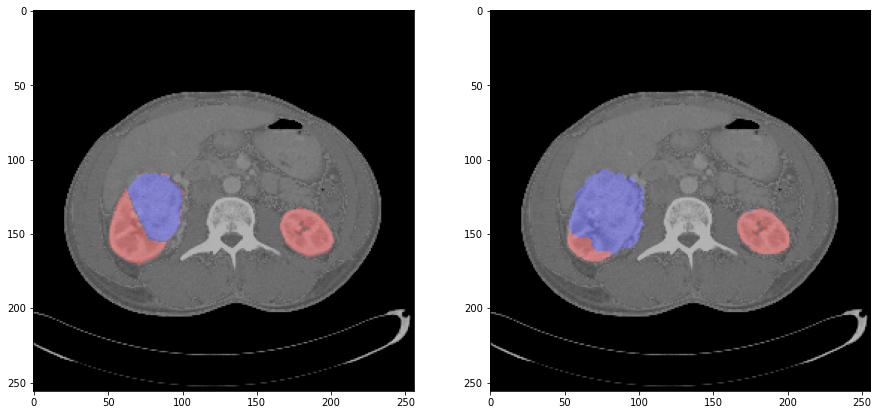

In [42]:
def hu_to_grayscale(volume, hu_min = -512, hu_max = 512):
    # Clip at max and min values if specified
    if hu_min is not None or hu_max is not None:
        volume = np.clip(volume, hu_min, hu_max)

    # Scale to values between 0 and 1
    mxval = np.max(volume)
    mnval = np.min(volume)
    im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)

    # Return values scaled to 0-255 range, but *not cast to uint8*
    # Repeat three times to make compatible with color overlay
    im_volume = 255*im_volume
    return np.stack((im_volume, im_volume, im_volume), axis=-1)

def class_to_color(segmentation, k_color = [255, 0, 0], t_color = [0, 0, 255]):
    # initialize output to zeros
    shp = segmentation.shape
    seg_color = np.zeros((shp[0], shp[1], shp[2], 3), dtype=np.float32)

    # set output to appropriate color at each location
    seg_color[np.equal(segmentation,1)] = k_color
    seg_color[np.equal(segmentation,2)] = t_color
    return seg_color

def overlay(volume_ims, segmentation_ims, segmentation, alpha):
    # Get binary array for places where an ROI lives
    segbin = np.greater(segmentation, 0)
    repeated_segbin = np.stack((segbin, segbin, segbin), axis=-1)
    # Weighted sum where there's a value to overlay
    overlayed = np.where(
        repeated_segbin,
        np.round(alpha*segmentation_ims+(1-alpha)*volume_ims).astype(np.uint8),
        np.round(volume_ims).astype(np.uint8)
    )
    return overlayed

#Visualize a case after resizing
def Visualize(case, rows, columns, width = 299, height = 299):
    cid = f'{case:05}'
    seg_best = f"/media/rami/New Volume/kits19/MIScnn/Pred_Results/weighted_dice"
    seg_worst = f"/media/rami/New Volume/kits19/MIScnn/Pred_Results/dice_loss"
    orig = f"/media/rami/New Volume/kits19/data_resized/case_{cid}/"
    img = f"/media/rami/New Volume/kits19/data_resized/case_{cid}/"
    img = os.path.join(img, 'imaging.nii.gz') 
    seg_best = os.path.join(seg_best, f'case_{cid}.nii.gz')
    seg_worst = os.path.join(seg_worst, f'case_{cid}.nii.gz')
    
    orig = os.path.join(orig, 'segmentation.nii.gz') 
    img = nib.load(img)
    
    seg_best = nib.load(seg_best)
    seg_worst = nib.load(seg_worst)
    orig = nib.load(orig)
    
    img = img.get_fdata()
    seg_best = seg_best.get_fdata()
    seg_worst = seg_worst.get_fdata()
    orig = orig.get_fdata()
    seg_best = seg_best.astype(np.float32)
    seg_worst = seg_worst.astype(np.float32)
    orig = orig.astype(np.float32)
    img_siz = hu_to_grayscale(img, -width, height)
    seg_best = class_to_color(seg_best, [255, 0, 0], [0, 0, 255])
    seg_worst = class_to_color(seg_worst, [255, 0, 0], [0, 0, 255])
    orig_siz = class_to_color(orig, [255, 0, 0], [0, 0, 255])
    
    plt.subplots(rows, columns,figsize=(15, 15))
    x = 85
    plt.subplot(rows, columns, 2)
    image_pred = overlay(img_siz, seg_best, img, 0.3)
    plt.imshow(image_pred[x], cmap='gray')
    plt.subplot(rows, columns, 1)
    image_orig = overlay(img_siz, orig_siz, img, 0.3)
    plt.imshow(image_orig[x], cmap='gray')
    plt.show()
    
    
rows = 1
columns = 2
case = 189
Visualize(case, rows, columns, 256, 256)

In [ ]:
for i in range(1, rows+1):
        for j in range(1, columns+1):
            plt.subplot(rows, columns, x)
            image = overlay(img_siz, seg_siz, img, 0.3)
            plt.imshow(image[x-1], cmap='gray')
            x += 1
    plt.show()

# Trials

In [13]:
model.load("3DUnet_log_cosh_dice_loss(250+100).hdf5")

In [18]:
filename = "evaluate.csv"
tf.keras.callbacks.CSVLogger(filename, separator=",", append=False)
csv_logger = CSVLogger('evaluate.csv')
history = model.evaluate(train_samples, validation_samples, epochs=20,
         iterations=None, callbacks=[csv_logger])

Epoch 1/20
320/320 [==============================] - 95s 298ms/step - loss: 0.1251 - dice_soft: 0.8054 - dice_crossentropy: 0.1190 - val_loss: 0.2024 - val_dice_soft: 0.6994 - val_dice_crossentropy: 0.1792
Epoch 2/20
320/320 [==============================] - 93s 290ms/step - loss: 0.1162 - dice_soft: 0.8050 - dice_crossentropy: 0.1178 - val_loss: 0.2149 - val_dice_soft: 0.6854 - val_dice_crossentropy: 0.2406
Epoch 3/20
320/320 [==============================] - 94s 294ms/step - loss: 0.1176 - dice_soft: 0.8030 - dice_crossentropy: 0.1188 - val_loss: 0.1824 - val_dice_soft: 0.7561 - val_dice_crossentropy: 0.1425
Epoch 4/20
320/320 [==============================] - 93s 290ms/step - loss: 0.1139 - dice_soft: 0.8052 - dice_crossentropy: 0.1171 - val_loss: 0.1972 - val_dice_soft: 0.7075 - val_dice_crossentropy: 0.1676
Epoch 5/20
320/320 [==============================] - 92s 287ms/step - loss: 0.1084 - dice_soft: 0.8137 - dice_crossentropy: 0.1145 - val_loss: 0.1854 - val_dice_soft: 0.74

In [ ]:
from miscnn.evaluation.cross_validation import cross_validation
# Run cross-validation function
cross_validation(validation_samples, model, k_fold=3, epochs=1000, iterations=150,
                 evaluation_path="evaluation", draw_figures=True, callbacks=[cb_lr, cb_es])

In [21]:
pred = model.predict(sample_list[204:205], return_output=True)

In [39]:
index = "case_00210"
prediction = model.predict([index], return_output=True)[0]

data_io.save_prediction(prediction, index)

In [ ]:
from miscnn.evaluation.cross_validation import cross_validation
# Run cross-validation function
cross_validation(validation_samples, model, k_fold=3, epochs=1000, iterations=150,
                 evaluation_path="evaluation", draw_figures=True, callbacks=[cb_lr, cb_es])